In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os

In [2]:
data = datasets.make_moons(n_samples=1000, noise= .2)

In [3]:
a1 = data[0]
y = data[1]
print(a1)

[[ 1.93892753  0.62855802]
 [ 2.01405427  0.39402291]
 [ 0.42052344 -0.55510748]
 ...
 [ 0.53208076 -0.59174408]
 [ 2.07596314 -0.10063288]
 [ 1.79920979  0.27248056]]


In [4]:
x1 = a1[:,0]
x2 = a1[:,1]

<AxesSubplot:>

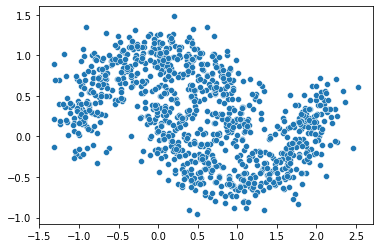

In [5]:
sb.scatterplot(x = x1 , y = x2)

# setting device to GPU

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Creating tensors

In [7]:
x1_ = torch.FloatTensor(a1 )
y = torch.FloatTensor(y).reshape(y.shape[0] , 1)

# Splitting Data into Test and Train

In [8]:
split = .8
split_ = int(x1_.shape[0] * split)


In [9]:
xtrain = x1_[:split_,]
xtest = x1_[split_:,]
ytrain = y[:split_ ,]
ytest = y[split_:,]

In [10]:
print(xtrain.shape)
print(ytest.shape)

torch.Size([800, 2])
torch.Size([200, 1])


# Creating Neural Network model

In [11]:
class Model(nn.Module):
    
    def __init__(self , infeature = 2 , h1 = 25 , h2 = 50 , h3 = 50 , h4 = 50 , h5 = 25 , outfeature = 1 ):
        super().__init__()
        self.fc1 = nn.Linear(infeature , h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.fc3 = nn.Linear(h2 , h3)
        self.fc4 = nn.Linear(h3 , h4)
        self.fc5 = nn.Linear(h4 , h5)
        self.fc6 = nn.Linear(h5 , outfeature)
        
        
    def forward(self , x):
        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc2(x1))
        x3 = torch.relu(self.fc3(x2))
        x4 = torch.relu(self.fc4(x3))
        x5 = torch.sigmoid(self.fc5(x4))
        x6 = (self.fc6(x5))
        
        return x6

# Creating random weights, baises and Moving the model to GPU

In [12]:
torch.manual_seed(42)
model = Model()
model.to(device)
print(model)

Model(
  (fc1): Linear(in_features=2, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=25, bias=True)
  (fc6): Linear(in_features=25, out_features=1, bias=True)
)


# Printing Parameters of Model

In [13]:
# for name , param in model.named_parameters():
#     print (name , param)

In [14]:
model.fc1.weight.shape

torch.Size([25, 2])

# Defining the criterian and optimizer

In [15]:
criterian = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.01)

# Moving data to GPU

In [16]:
xtrain = xtrain.to(device)
ytrain = ytrain.to(device)

xtest = xtest.to(device)
ytest = ytest.to(device)

# using numpy.mgrid to plot the values

In [17]:
grid = np.mgrid[-2.0:2.5:200j,-1.5:2:200j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid
grid_2d_ = torch.FloatTensor(grid_2d)
grid_2d_ = grid_2d_.to(device)

In [18]:
def make_plot(X , Y, XX=None, YY=None, preds=None , file_name= None):

    if(XX is not None and YY is not None and preds is not None):

        plt.contour(XX, YY, preds.reshape(XX.shape))
    plt.scatter(X[:, 0], X[:, 1])
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [19]:
def callbacks(index):
    file_name = str(index//5)
    file_path = os.path.join(location, file_name)
    
    predic = model.forward(grid_2d_)
    predic = predic.cpu()
    make_plot(xtest.cpu(),ytest.cpu() , XX=XX, YY=YY, preds=predic.detach().numpy() , file_name=file_path)

# Training the model

In [20]:
epoch = 20000
losses = []
callback = callbacks
location = "C:\\Users\\User\\Pictures\\work\\python folder\\torchimages\\"
for i in range(epoch):
        
    i = i + 1
    ypred = model.forward(xtrain)
    loss = criterian(ypred , ytrain)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i % 5 == 0):
        if(callback is not None):
            callback(i)
    
        

# moving values of loss to CPU and Ploting

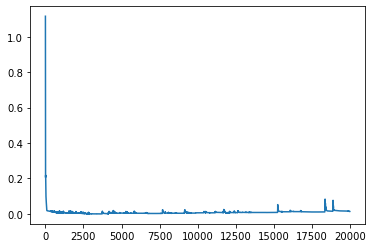

In [21]:
loss = torch.tensor(losses)
loss.cpu()

plt.plot(range(epoch) , loss)

In [22]:
#model.state_dict()

In [23]:
#model.eval()

In [24]:
weight = model.fc6.weight
baise = model.fc6.bias

print(weight)
print(baise)

Parameter containing:
tensor([[ 0.2404,  0.5194,  1.0962,  1.0760, -0.0769,  1.0059, -0.5215,  0.4881,
         -0.2618, -0.3070, -0.5631,  0.8592, -0.4093, -0.7344,  0.7612, -0.4187,
          0.4962,  0.5055,  0.0055,  0.5738,  0.1921, -0.2166, -0.0704,  0.0245,
         -0.5567]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.2576], device='cuda:0', requires_grad=True)


# Predicting values using test data

In [25]:
prey_y = model.forward(xtest)
prey_y = prey_y.cpu()

In [26]:
def probtoclass(prob):
    prob_ = np.copy(prob)
    prob_[prob_ > 0.5] = 1
    prob_[prob_ <= 0.5] = 0
    return prob_


In [27]:
predy = probtoclass(prey_y.detach().numpy())
predy_ = torch.tensor(predy)

In [28]:
ytest = ytest.cpu()


# Accuracy achieved on the test set

In [29]:
c = torch.eq(ytest , predy_)
Accuracy = torch.mean(c.long().float())
Accuracy

tensor(0.9600)

In [30]:
grid_2d_.shape

torch.Size([40000, 2])

In [31]:
predic = model.forward(grid_2d_)
predic = predic.cpu()
predic.shape

torch.Size([40000, 1])

# Plotting the final results

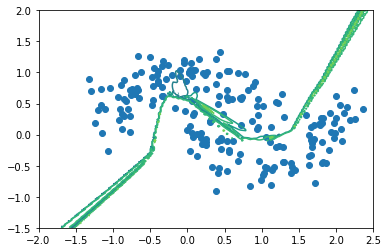

In [32]:
make_plot(xtest.cpu(),ytest.cpu() , XX=XX, YY=YY, preds=predic.detach().numpy())

In [33]:
xtest.shape

torch.Size([200, 2])

In [34]:
ytest.shape

torch.Size([200, 1])